In [12]:
# import sys
# sys.path.append('../../')
import cresthh
from cresthh import anuga
from osgeo import gdal
from glob import glob
from affine import Affine
import geopandas as gpd
from pyproj import Proj, CRS, transform


%matplotlib inline

# Allow inline jshtml animations
from matplotlib import rc
rc('animation', html='jshtml')

In [2]:
bounding_polygon= gpd.read_file('watershed_shp/watershed.shp')
# bounding_polygon= gpd.read_file('area/domain.shp')
# Elevation Data
# topography_file = 'DEM.tif'
topography_file = 'DEM_filled.tif'
# topography_file= '/home/ZhiLi/CRESTHH/data/precip/imerg20170825S150000.tif'

# Resolution for most of the mesh
base_resolution = 10  # m^2


In [3]:
# lons= np.array(bounding_polygon.exterior[0].coords)[:,0]; lats=np.array(bounding_polygon.exterior[0].coords)[:,1]
lons= np.array(bounding_polygon.exterior[1].coords)[:,0]; lats=np.array(bounding_polygon.exterior[1].coords)[:,1]

In [4]:
myProj = Proj("+proj=utm +zone=15, +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

In [5]:
utm_coords= [myProj(lon,lat) for (lon, lat) in zip(lons, lats)]

Figure files for each frame will be stored in _plot


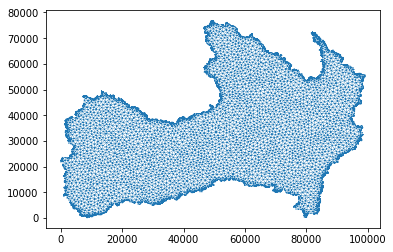

In [6]:
domain = anuga.create_domain_from_regions(
            utm_coords,
            boundary_tags={'bottom': [0]},
            maximum_triangle_area=1000000,
            
            )

# domain= anuga.create_domain_from_rectangular()

# Basic geometry and bounding polygon
# xleft   = -95.05
# xright  = -95.83
# ybottom = 29.79
# ytop    = 30.18

# point_sw = [xleft, ybottom]
# point_se = [xright, ybottom]
# point_nw = [xleft, ytop]    
# point_ne = [xright, ytop]

# bounding_polygon = [point_se,
#                     point_ne,
#                     point_nw,
#                     point_sw]



# domain= anuga.create_domain_from_regions(bounding_polygon,boundary_tags={'bottom': [0],},maximum_triangle_area=0.0005)

# domain= anuga.rectangular_cross_domain

domain.set_name('excessive_rain') # Name of sww file
dplotter = anuga.Domain_plotter(domain)  
plt.triplot(dplotter.triang, linewidth = 0.4);

In [7]:
print 'Number of elements:',domain.number_of_elements

Number of elements: 10203


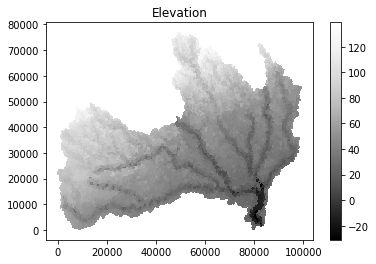

In [8]:
domain.set_proj("+proj=utm +zone=15, +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
domain.set_quantity('elevation', filename=topography_file, location='centroids') # Use function for elevation
domain.set_quantity('friction', 0.03, location='centroids')                        # Constant friction 
domain.set_quantity('stage', expression='elevation', location='centroids')         # Dry Bed 
domain.set_quantity('SS0', 0, location='centroids')
domain.set_quantity('SI0', 0, location='centroids')
domain.set_quantity('W0', 0, location='centroids')
domain.set_quantity('RainFact', 0.5, location='centroids')
domain.set_quantity('Ksat', 0.5, location='centroids')
domain.set_quantity('WM', 0.5, location='centroids')
domain.set_quantity('B', 0.5, location='centroids')
domain.set_quantity('IM', 0.5, location='centroids')
domain.set_quantity('KE', 0.5, location='centroids')
domain.set_quantity('coeM', 0.5, location='centroids')
domain.set_quantity('expM', 0.5, location='centroids')
domain.set_quantity('coeR', 0.5, location='centroids')
domain.set_quantity('coeS', 0.5, location='centroids')
domain.set_quantity('KS', 0.5, location='centroids')
domain.set_quantity('KI', 0.5, location='centroids')
domain.set_evap_dir('/home/ZhiLi/CRESTHH/data/evap', pattern='cov_et17%m%d.asc.tif', freq='1D')
# domain.set_precip_dir('/home/ZhiLi/CRESTHH/data/precip',pattern='nimerg%Y%m%dS%H%M%S.tif', freq='1H')
domain.set_precip_dir('/hydros/MengyuChen/mrmsPrecRate',pattern='PrecipRate_00.00_%Y%m%d-%H%M00.grib2-var0-z0.tif', freq='2M')
domain.set_timestamp('20170825180000', format='%Y%m%d%H%M%S')
domain.set_time_interval('1H')


plt.tripcolor(dplotter.triang, 
              facecolors = dplotter.elev, 
              cmap='Greys_r')
plt.colorbar();
plt.title("Elevation");

In [9]:
Br = anuga.Reflective_boundary(domain)
Bt = anuga.Transmissive_boundary(domain)

domain.set_boundary({'bottom':   Bt,
                     'exterior': Br})

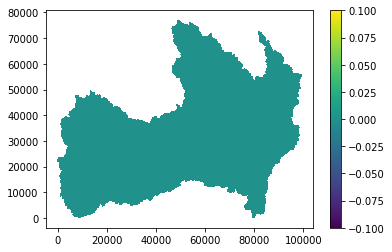

In [10]:
domain.quantities['SI0'].plot_quantity()

In [10]:
# Rain = anuga.Quantity(domain, name='Rain')
# ET= anuga.Quantity(domain, name='ET')
# forcing_op= anuga.Rate_operator(domain, rate=Rain+ET)
# rain_op = anuga.Rate_operator(domain, rate = Rain)
# et_op = anuga.Rate_operator(domain, rate= Evap)
# Rain= anuga.Rate_operator(domain, rate=lambda t: 5 if t<5 else 10)
for i,t in enumerate(domain.evolve(yieldstep=120, duration=3600*24)):
#     current_rain_file = sorted(glob(external_dir+'/*.tif'))[i]
#     print(current_rain_file)
#     Rain.set_values_from_utm_grid_file(current_rain_file, location='centroids')
#     ET.set_values_from_utm_grid_file(current_rain_file, location='centroids')
#     dplotter.plot_depth_frame()
    dplotter.save_depth_frame(vmin=0.0, vmax=1)
    domain.print_operator_timestepping_statistics()
    domain.print_timestepping_statistics()
    domain.report_water_volume_statistics()

    stage = domain.get_quantity('stage')
    elev  = domain.get_quantity('elevation')
    height = stage - elev
    print 'integral = ', height.get_integral()    
# Read in the png files stored during the evolve loop
dplotter.make_depth_animation() 

evolving elements: 10203
    operator_0: Integrating the boundary flux
Time = 0.0000, steps=0 (10s)
 
    Volume V is: 0.0
    Boundary Flux integral BF:  [0.]
    (rate + inlet) Fractional Step volume integral FS:  0.0
    V - BF - FS - InitialVolume : [0.]
 
integral =  0.0
    operator_0: Integrating the boundary flux
Time = 120.0000, delta t = 1000.00000000, steps=1 (1s)
 
    Volume V is: 183822.37685697185
    Boundary Flux integral BF:  [0.]
    (rate + inlet) Fractional Step volume integral FS:  0.0
    V - BF - FS - InitialVolume : [183822.37685697]
 
integral =  183822.37685729848
    operator_0: Integrating the boundary flux
Time = 240.0000, delta t = 788.29974762, steps=1 (0s)
 
    Volume V is: 367644.7537132367
    Boundary Flux integral BF:  [0.]
    (rate + inlet) Fractional Step volume integral FS:  0.0
    V - BF - FS - InitialVolume : [367644.75371324]
 
integral =  367644.75371311884
    operator_0: Integrating the boundary flux
Time = 360.0000, delta t in [1.601069

KeyboardInterrupt: 

<Figure size 800x480 with 0 Axes>

In [14]:
3600*24

86400

In [8]:
import pstats

In [10]:
p = pstats.Stats('profile_res.txt')

In [13]:
p.sort_stats('cumtime')
p.print_stats()

<pstats.Stats instance at 0x7fa35bad1878>

Tue Jun  9 14:16:51 2020    profile_res.txt

         1874426 function calls (1868612 primitive calls) in 22.602 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.019    0.019   22.612   22.612 profile.py:1(<module>)
      182    0.002    0.000   20.620    0.113 /home/ZhiLi/CRESTHH/python2/lib/python2.7/site-packages/anuga/shallow_water/shallow_water_domain.py:2418(evolve)
      182    0.047    0.000   19.563    0.107 /home/ZhiLi/CRESTHH/python2/lib/python2.7/site-packages/anuga/abstract_2d_finite_volumes/generic_domain.py:1653(_evolve_base)
      955    0.056    0.000    9.510    0.010 /home/ZhiLi/CRESTHH/python2/lib/python2.7/site-packages/anuga/abstract_2d_finite_volumes/generic_domain.py:1976(evolve_one_euler_step)
      182    0.557    0.003    8.638    0.047 /home/ZhiLi/CRESTHH/python2/lib/python2.7/site-packages/anuga/abstract_2d_finite_volumes/quantity.py:1471(set_values_from_lat_long_tif_file)
      

<pstats.Stats instance at 0x7fa35bad1878>